In [1]:
import os
import sys
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from srcs.engdataset import ENGDataset
import utils.preprocessing as pre
import utils.classify as classify
from constants import *

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from collections import namedtuple, Counter
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import logging

%load_ext autoreload
%autoreload 2

plt.rcParams.update({"figure.dpi": 150})
plt.rcParams['axes.axisbelow'] = True
logging.getLogger().setLevel(logging.INFO)
matplotlib.rcParams.update({'font.size': 6})

plt.rcParams.update({
            "figure.dpi": 150, 'font.size': 10,
            'figure.figsize': (5,3), 'axes.axisbelow': True,
            'axes.edgecolor': COLOR_DICT['clouds'], 'axes.linewidth': 0.4
        })
logging.getLogger().setLevel(logging.INFO)

# Load post-processed data for LDA analysis

In [2]:
# load raw ENG for the following parameters
day = 16                   # day of recording
session = '01'             # session of recording
feature = 'power'
overlap_perc = 0.5          # overlap ratio
organize_strat = 'flx_vs_ext_separate'     #  defines how to prepare the dataset: 'flx_vs_ext_separate' or 'flx_vs_ext_together' or'flx_vs_ext_combined'

save_figs = True


# Select only few classes from all for classification
Gest_namedtup = namedtuple('gesture', ['id', 'phase'])
sel_gest_phase = [Gest_namedtup(0, 'Close'),
                  Gest_namedtup(1, 'Close'),
                  # Gest_namedtup(2,'Close'),
                  Gest_namedtup(3, 'Close'),
                  Gest_namedtup(4, 'Close')]


In [3]:
eng_dataset = ENGDataset(day= day, session=session, load_raw_data = True, save_figs=save_figs)
pipeline = {'bp_order': 3, 'bp_cutoff_freq': np.array([300, 2000]), 'notch_bandwidth': 0.5, 'notch_reject': 50}
eng_dataset.filt_pipeline = pipeline

INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG.mat
INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG_ok.mat
INFO:root:Creating dictionary of reps count per task: {0: 10, 1: 10, 2: 10, 3: 7, 4: 10}
INFO:root:Time column of post_data(7157879,) 
Rec column of post_data(56, 7157879)


In [4]:
# update global CLASS_TO_GEST
CLASS_TO_GEST = {i:f'{eng_dataset.task_order[gest.id]} {gest.phase}' for i, gest in enumerate(sel_gest_phase)}
print(CLASS_TO_GEST)

{0: 'Tripod Close', 1: 'ThOpp. Close', 2: 'UlnarFing. Close', 3: 'FingAbd. Close'}


In [5]:
# load filtered ENG data
filt_filename = f"day{eng_dataset.day}{eng_dataset.session}_eng_filt_{eng_dataset.filt_pipeline['bp_cutoff_freq'][0]}_{eng_dataset.filt_pipeline['bp_cutoff_freq'][1]}.pkl"
filt_df = pd.read_pickle(os.path.join(FILTERED_DIR, filt_filename))
eng_dataset.filt_df = filt_df

# delete raw
eng_dataset._detete_raw_data()

In [6]:
#create directory for figures if it doesn't exist
FIG_LDA_DIR = os.path.join('figures', f'day{eng_dataset.day}{eng_dataset.session}', 'LDA' )

if not os.path.exists(FIG_LDA_DIR):
    os.makedirs(FIG_LDA_DIR)

In [7]:
def apply_lda_transform(eng_dataset, feature, organize_strat, wind_size, overlap_perc, 
                        sel_gest_phase, over_entire_rep):
    
    # Compute feature over overlapping time windows for all gestures
    input_df, labels_map = classify.prepare_input_df(eng_dataset, feature, organize_strat, wind_size, overlap_perc, over_entire_rep)
    avg_win_per_class = input_df.groupby([LABEL_COL], as_index=True)[FEAT_WIN_COL].count() / input_df.groupby([LABEL_COL], as_index=True)[REP_ID_COL].nunique()
    print(f"Average number of windows per class\n{avg_win_per_class}\n")

    # Get corresponding label of the gesture given the phase of gesture
    select_class, _ = pre.encode_gest_phase(eng_dataset, sel_gest_phase, labels_map)
    print(select_class)
    # Select the gestures and phases of interest
    input_df_sub = input_df[input_df['class_label'].isin(select_class)]

    # Retrieve LDA_input and LDA_target
    aux_cols = [TIME_VAR, REP_ID_COL, LABEL_COL, FEAT_WIN_COL]
    lda_input = input_df_sub.drop(aux_cols, axis=1)
    lda_target = input_df_sub[LABEL_COL]
    print(f"LDA input: {lda_input.shape}   LDA target: {lda_target.shape}")

    # Normalize the data
    scaler = StandardScaler()
    lda_input_scaled = pd.DataFrame(scaler.fit_transform(lda_input))

    # Apply LDA transformation
    lda_transform = LDA(n_components=2).fit_transform(lda_input_scaled, lda_target)
    print(f"LDA input: {lda_input.shape}   LDA-transform: {lda_transform.shape}")

    # Organize in a DataFrame
    lda_transform_df = pd.DataFrame(lda_transform, columns=['LDA1', 'LDA2'])
    lda_transform_df[LABEL_VAR] = lda_target.values
    lda_transform_df['gest_name'] = lda_transform_df[LABEL_VAR].map(labels_map)

    # Ensure gestures are ordered
    lda_transform_df = lda_transform_df[lda_transform_df['gest_name'].isin(list(CLASS_TO_GEST.values()))]
    
    return lda_transform_df

In [8]:
# for a single wind_size
# wind_size = 0.2  # in seconds
# apply_lda_transform(eng_dataset, feature, organize_strat, wind_size, overlap_perc, sel_gest_phase,
#                     over_entire_rep=True)

Average number of windows per class
class_label
0     19.0
1     19.0
2     19.0
3     19.0
4     19.0
5     19.0
6     19.0
7     19.0
8     19.0
9     19.0
10    89.3
dtype: float64

0 Tripod
1 ThOpp.
3 UlnarFing.
4 FingAbd.
[0, 2, 6, 8]
LDA input: (703, 56)   LDA target: (703,)
LDA input: (703, 56)   LDA-transform: (703, 2)
Average number of windows per class
class_label
0     12.0
1     12.0
2     12.0
3     12.0
4     12.0
5     12.0
6     12.0
7     12.0
8     12.0
9     12.0
10    56.4
dtype: float64

0 Tripod
1 ThOpp.
3 UlnarFing.
4 FingAbd.
[0, 2, 6, 8]
LDA input: (444, 56)   LDA target: (444,)
LDA input: (444, 56)   LDA-transform: (444, 2)
Average number of windows per class
class_label
0      9.0
1      9.0
2      9.0
3      9.0
4      9.0
5      9.0
6      9.0
7      9.0
8      9.0
9      9.0
10    42.3
dtype: float64

0 Tripod
1 ThOpp.
3 UlnarFing.
4 FingAbd.
[0, 2, 6, 8]
LDA input: (333, 56)   LDA target: (333,)
LDA input: (333, 56)   LDA-transform: (333, 2)
break
break
b

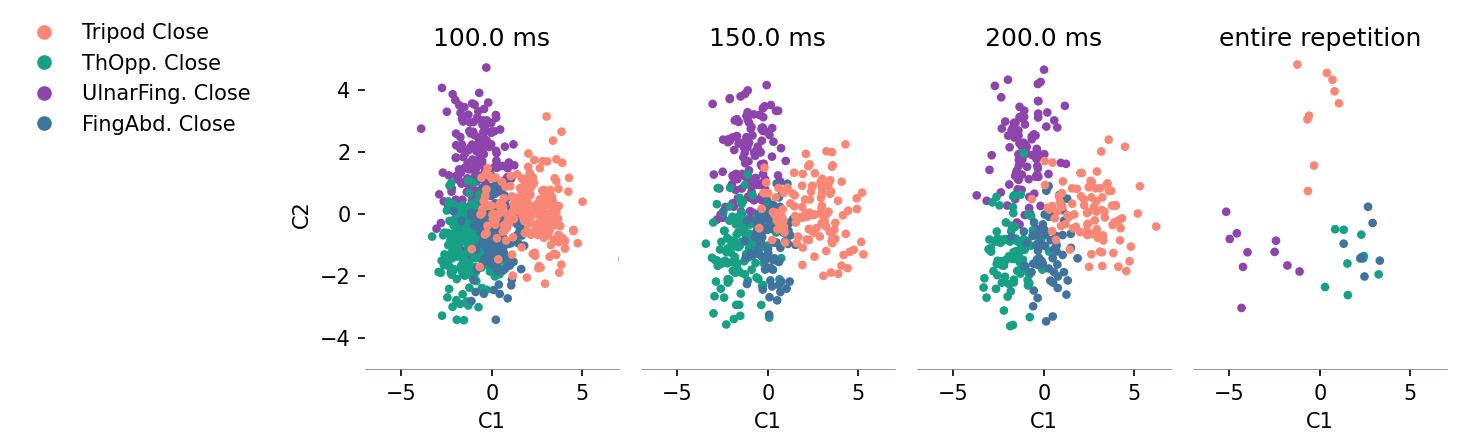

In [9]:
# Plot lda-transformed data for multiple window sizes
wind_sizes = [0.1, 0.15, 0.20, 1]
custom_cmap = ListedColormap(sns.color_palette(GEST_COLORS).as_hex())
marker_size = 10

fig = plt.figure(figsize=(8,3))
gs = gridspec.GridSpec(nrows=1, ncols=len(wind_sizes))
for col, wind_size in enumerate(wind_sizes):
    ax = fig.add_subplot(gs[col])
    if wind_size==1:
        over_entire_rep_flag = True
    else:
        over_entire_rep_flag = False
    lda_transform_df = apply_lda_transform(eng_dataset, feature, organize_strat, wind_size, overlap_perc, sel_gest_phase,
                                           over_entire_rep_flag)

    ax.scatter(lda_transform_df.LDA1,  lda_transform_df.LDA2, s=marker_size,
                          c=lda_transform_df.gest_name.astype('category').cat.codes, 
                          alpha=1, 
                          cmap=custom_cmap) 

    ax.set_xlabel("C1", size=10)
    if col==0:
        ax.set_ylabel("C2", size=10)
    else:
        ax.set_yticks([])
    ax.set_xlim([-7, 7])
    ax.set_ylim([-5, 5])
    if col!=len(wind_sizes)-1:
        ax.set_title(f'{wind_size * 1000} ms')
    else:
        ax.set_title(f'entire repetition')

    sns.despine(ax=ax, trim=False,left=True)

# add legend
handles = [plt.Line2D([], [], color=GEST_COLORS[i], linestyle='None', marker='o') for i in range(len(CLASS_TO_GEST))]
legend_label = list(CLASS_TO_GEST.values())
leg = fig.legend(handles=handles, labels=legend_label,
                 loc='upper right', bbox_to_anchor=(0, 1.),
                 ncols=1, frameon=False)

fig.tight_layout()

# save figure
if save_figs:
    filename = f"day{DAY}{SESSION}_lda_tripod_ol_{int(overlap_perc*100)}_{sel_gest_phase[0].phase}.png"
    fig.savefig(os.path.join(FIG_LDA_DIR, filename), dpi=300, bbox_inches='tight')
